In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
print(np.max(x_train), np.min(x_train))

255 0


In [9]:
# x = (x - u) / std
#通过原有sk的标准化进行处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
#先reshape变为二维（相当于1列）的目的是对每一个像素点进行标准化（让其等价）
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
#这个是验证集，验证集用的也是测试集的均值和方差
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
#这个是测试集
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [7]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


In [10]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [11]:
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0055 - accuracy: 0.6804 - val_loss: 0.6741 - val_accuracy: 0.7766
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6258 - accuracy: 0.7845 - val_loss: 0.5691 - val_accuracy: 0.8054
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5537 - accuracy: 0.8074 - val_loss: 0.5222 - val_accuracy: 0.8202
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5146 - accuracy: 0.8187 - val_loss: 0.4925 - val_accuracy: 0.8326
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4883 - accuracy: 0.8278 - val_loss: 0.4720 - val_accuracy: 0.8370
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4688 - accuracy: 0.8343 - val_loss: 0.4584 - val_accuracy: 0.8392
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4536 - accuracy: 0.8398 - val_loss: 0.4443 - val_accuracy:

In [12]:
print(type(history.history))
print(history.history)

<class 'dict'>
{'loss': [1.0054773092269897, 0.6258463859558105, 0.5536544919013977, 0.5146304965019226, 0.48831719160079956, 0.4687653183937073, 0.4536149501800537, 0.4408304989337921, 0.43051275610923767, 0.4214595556259155], 'accuracy': [0.680400013923645, 0.7844908833503723, 0.807381808757782, 0.8187454342842102, 0.8277636170387268, 0.8343091011047363, 0.8398363590240479, 0.8438363671302795, 0.8483454585075378, 0.8508909344673157], 'val_loss': [0.6740957498550415, 0.5690630078315735, 0.5222492814064026, 0.49249428510665894, 0.47199326753616333, 0.45843660831451416, 0.44428202509880066, 0.4342775046825409, 0.42608824372291565, 0.4171502888202667], 'val_accuracy': [0.7766000032424927, 0.805400013923645, 0.8202000260353088, 0.8325999975204468, 0.8370000123977661, 0.8392000198364258, 0.8465999960899353, 0.8496000170707703, 0.8533999919891357, 0.8547999858856201]}


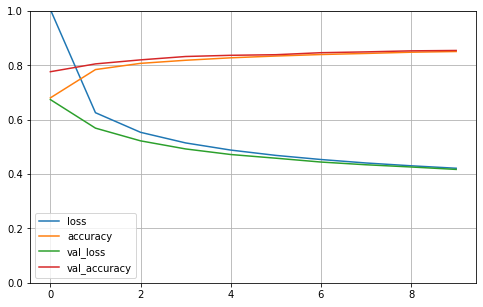

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.45520806312561035, 0.8363999724388123]